In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [187]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=128, d_state=16, perception='fullconv', kernel_size=3, # changed img_size
    init_state="point", padding_mode="circular", dt=0.01, dropout=0.1, # changed dropout and initial state
    
    prompts="a circle;a square", spatial_scales="1.", clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_spatial_softmax=0.0, # changed spatial softmax
    
    rollout_steps=512, bptt_steps=16, pool_size=128, # changed the rollout steps and the pool size
    bs=8, lr=3e-4, n_iters=100000, clip_grad_norm=1.
)

seeds = np.arange(6)

prompts_sweep = ["a very fat cat", "a biological cell", "bacteria under the microscope", "particles in a gas",
                 "a lizard", "an ecosystem of life", "a random thing",
                 "a green circle"]
img_size_sweep = [4, 8, 16, 32, 64, 128]
# spatial_scales_sweep = ["0.01", "0.033", "0.1", "0.33", "1."]

# coef_spatial_softmax_sweep = [0., 1e-2, 3e-2, 1e-1]
# coef_spatial_softmax_sweep = [0.]+np.logspace(-3, 0, num=15).tolist()

prompts_large_sweep = ["a single fat cat", "a single green tree", "a single apple", "a single nature landscape", "a single fish"]
prompts_small_sweep = ["a biological cell", "a bacteria under the microscope", "a scale pattern", "a fractal pattern", "grid pattern"]

cfgs = []
for seed in seeds:
    spatial_scales = "1."
    for prompts in prompts_large_sweep:
        cfg = cfg_default.copy()
        cfg.update(seed=seed, prompts=prompts, spatial_scales=spatial_scales)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_scale5/{seed}_{prompts}_{spatial_scales}")
        cfgs.append(cfg)
    
    spatial_scales = "0.015625"
    for prompts in prompts_small_sweep:
        cfg = cfg_default.copy()
        cfg.update(seed=seed, prompts=prompts, spatial_scales=spatial_scales)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_scale5/{seed}_{prompts}_{spatial_scales}")
        cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

60


In [188]:
1/8/8

0.015625

In [189]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_nca_temporal_emergence.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale5/0_a single fat cat_1."                      --dtype="float32" --device="cuda:0" --img_size=128 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.1 --prompts="a single fat cat"                --spatial_scales="1."       --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_spatial_softmax=0.0 --rollout_steps=512 --bptt_steps=16 --pool_size=128 --bs=8 --lr=0.0003 --n_iters=100000 --clip_grad_norm=1.0
python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale5/0_a single green tree_1."                   --dtype="float32" --device="cuda:0" --img_size=128 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.1 --prompts="a single green tree"             --spatial_scales="1."       --clip_m

# Visualize Results

In [286]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [287]:
import copy
df = []
for cfg in cfgs:
    save_dir = cfg['save_dir']
    data = util.load_pkl(save_dir, 'data')
    dfi = copy.copy(cfg)
    df.append(dfi)
df = pd.DataFrame(df)

0it [00:00, ?it/s]

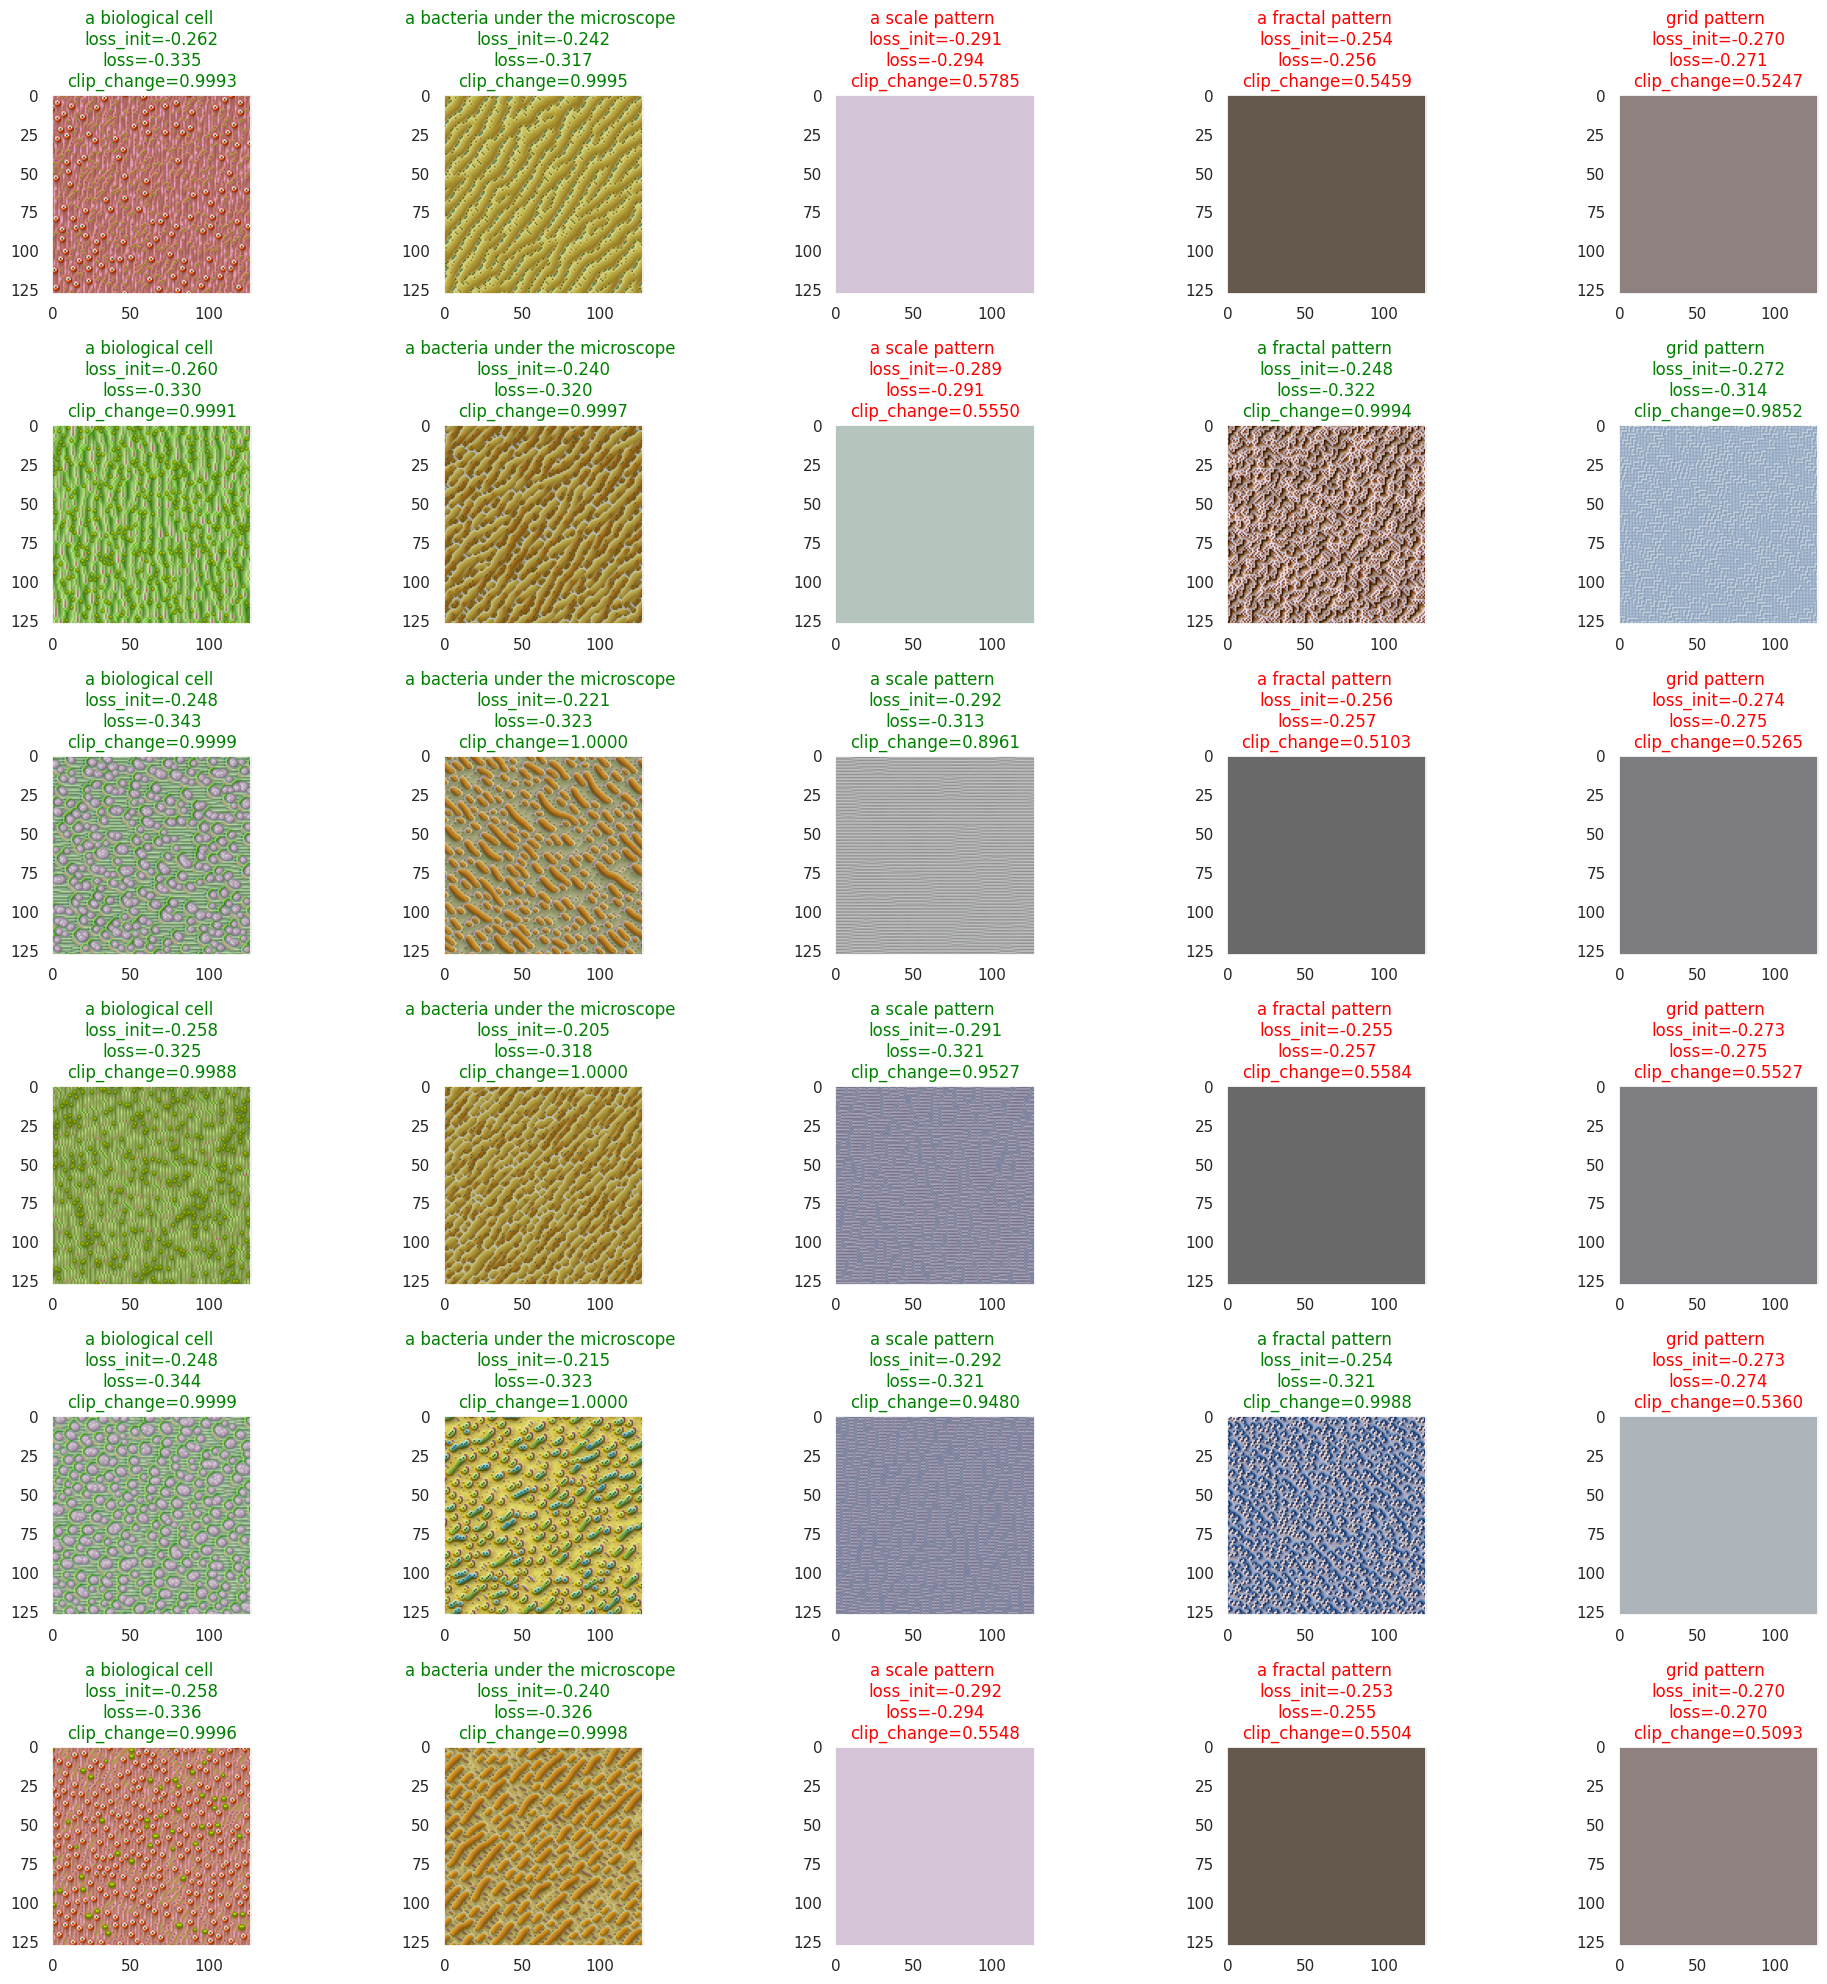

In [288]:
plt.figure(figsize=(20, 20))
iplt = 0

for _, dfi in tqdm(df[df['spatial_scales']!="1."].iterrows()):
    vid = util.load_pkl(dfi['save_dir'], "vid").astype(np.uint8)
    loss_init = util.load_pkl(dfi['save_dir'], 'data')['loss'][:100].mean().item()
    loss = util.load_pkl(dfi['save_dir'], 'data')['loss'][-100:].mean().item()
    clip_change = torch.softmax(torch.tensor([-loss_init, -loss])*100, dim=0)[-1].item()

    iplt += 1
    plt.subplot(6, 5, iplt)
    plt.imshow(vid[511])
    plt.title(f"{dfi['prompts']} \n{loss_init=:.3f}\n{loss=:.3f}\n{clip_change=:.4f}", color='red' if clip_change<0.75 else 'green')
    plt.grid(False)

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

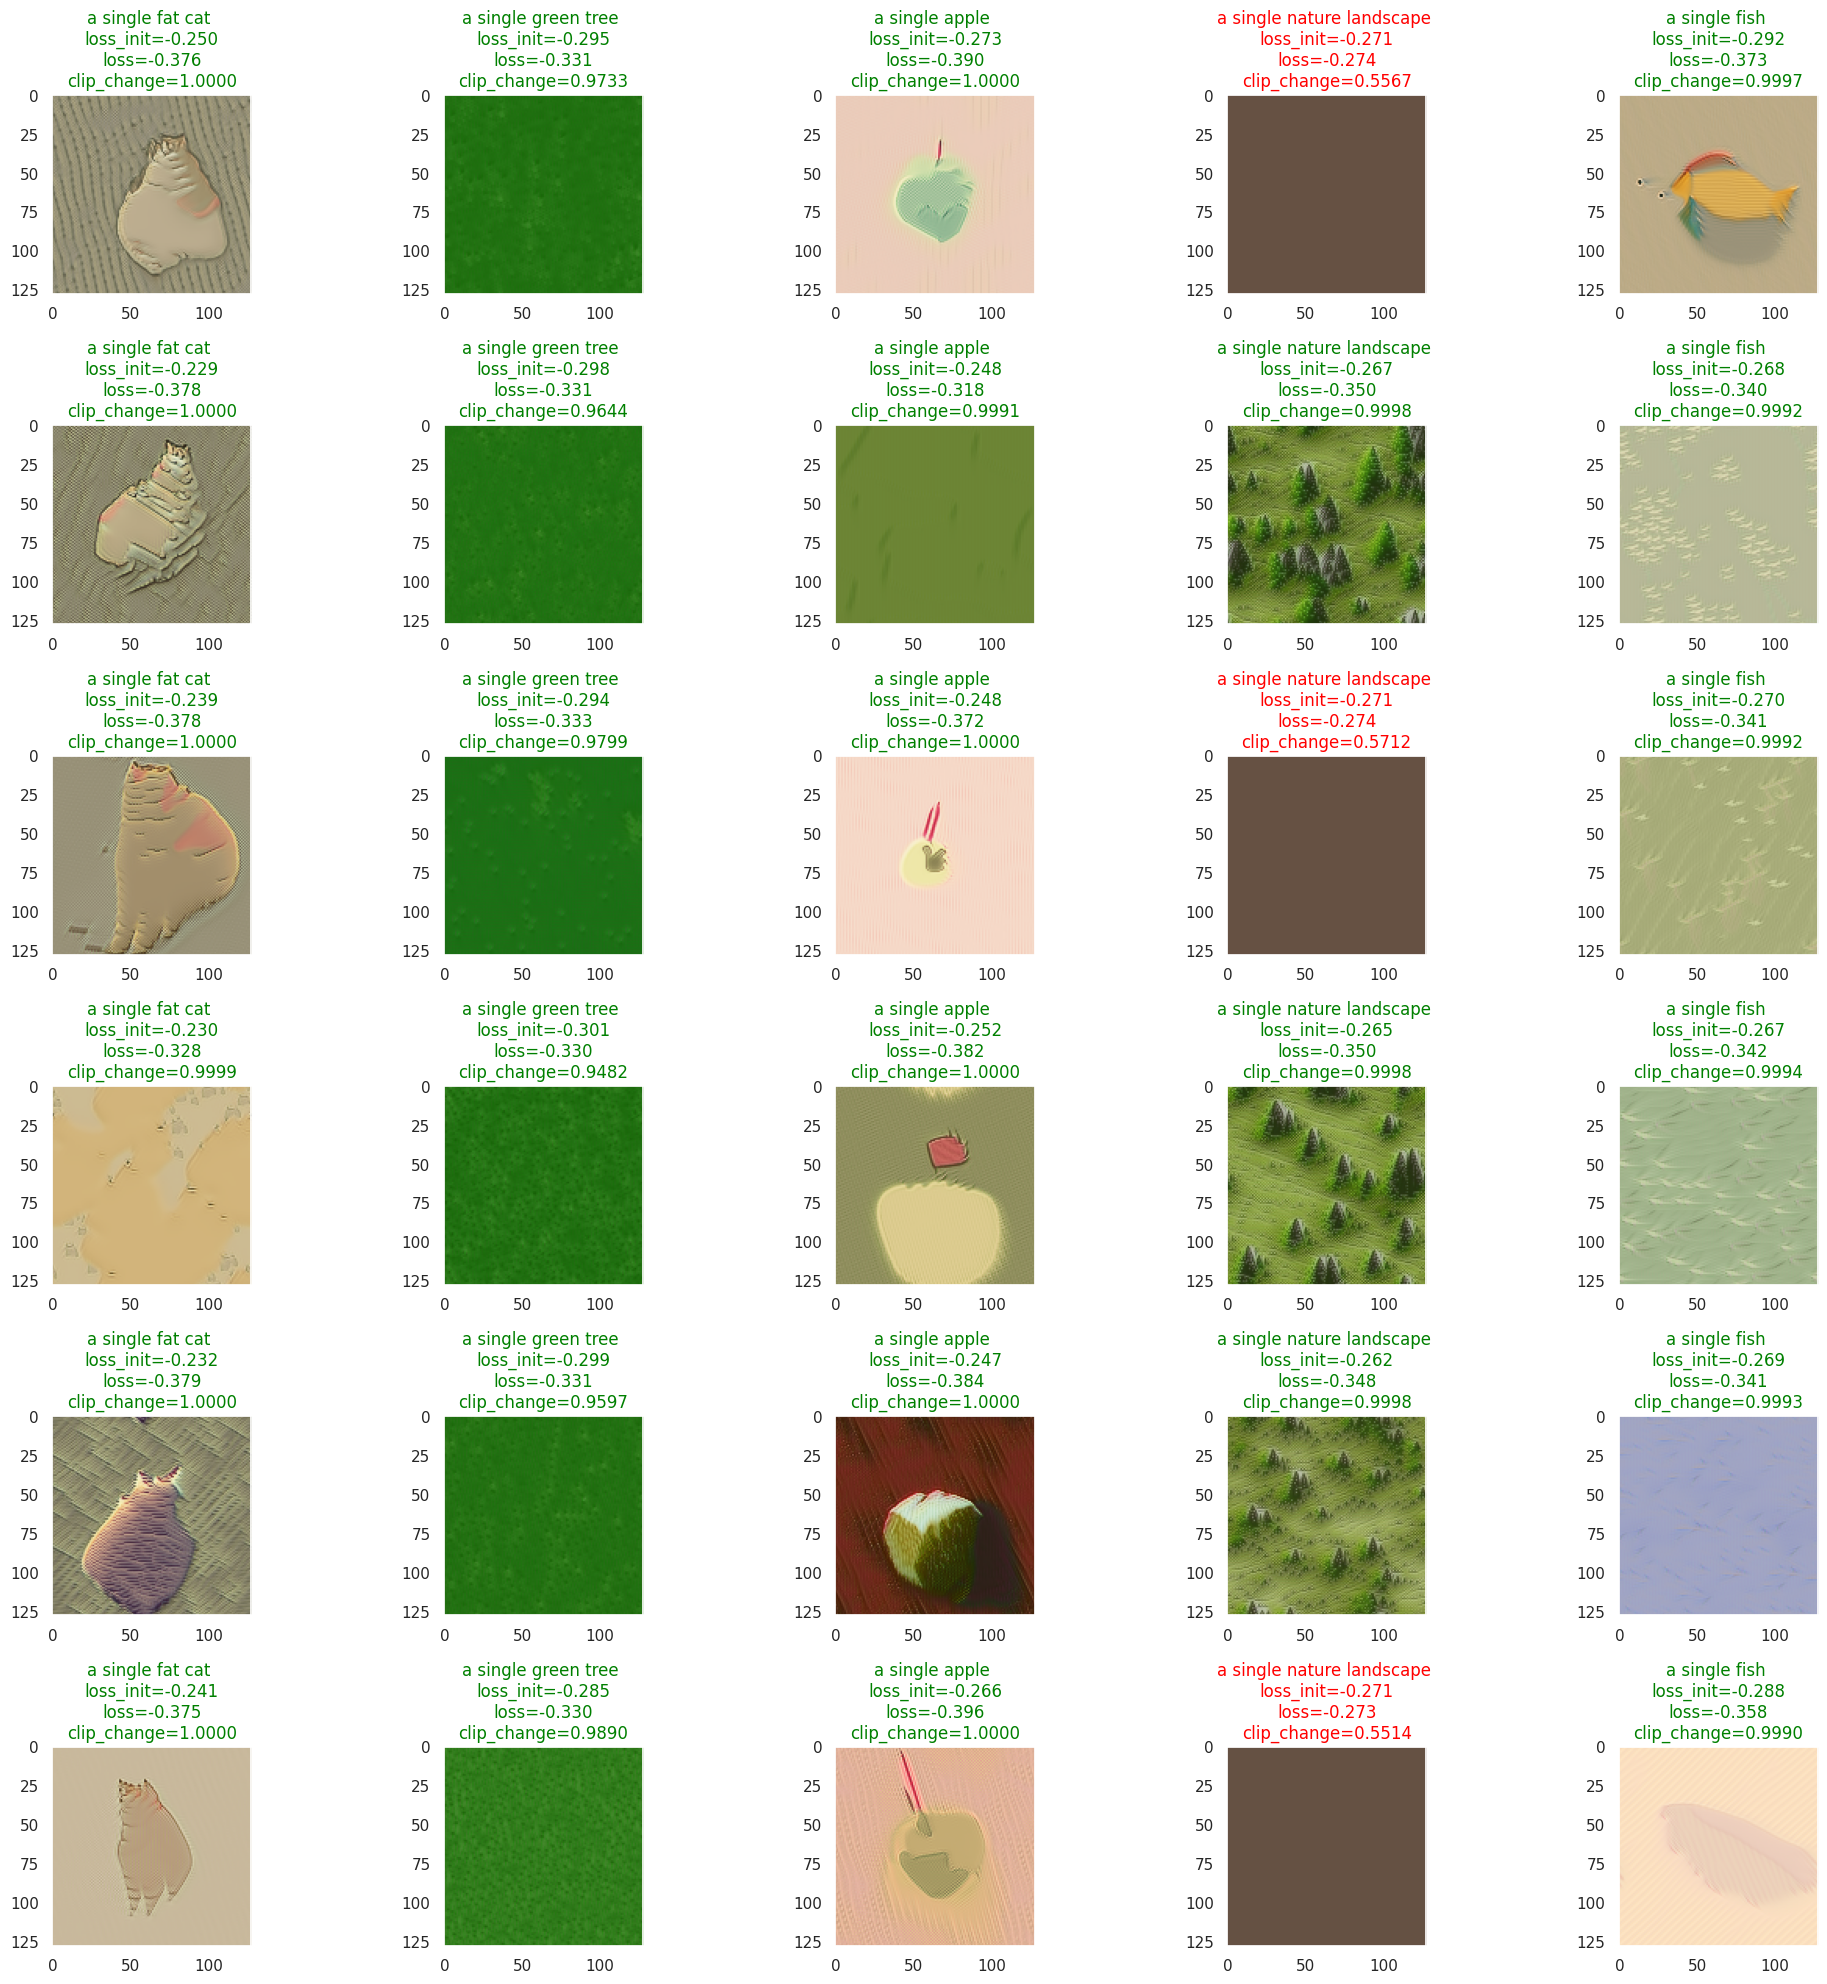

In [289]:
plt.figure(figsize=(20, 20))
iplt = 0

for _, dfi in tqdm(df[df['spatial_scales']=="1."].iterrows()):
    vid = util.load_pkl(dfi['save_dir'], "vid").astype(np.uint8)
    loss_init = util.load_pkl(dfi['save_dir'], 'data')['loss'][:100].mean().item()
    loss = util.load_pkl(dfi['save_dir'], 'data')['loss'][-100:].mean().item()
    clip_change = torch.softmax(torch.tensor([-loss_init, -loss])*100, dim=0)[-1].item()

    iplt += 1
    plt.subplot(6, 5, iplt)
    plt.imshow(vid[511])
    plt.title(f"{dfi['prompts']} \n{loss_init=:.3f}\n{loss=:.3f}\n{clip_change=:.4f}", color='red' if clip_change<0.75 else 'green')
    plt.grid(False)

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

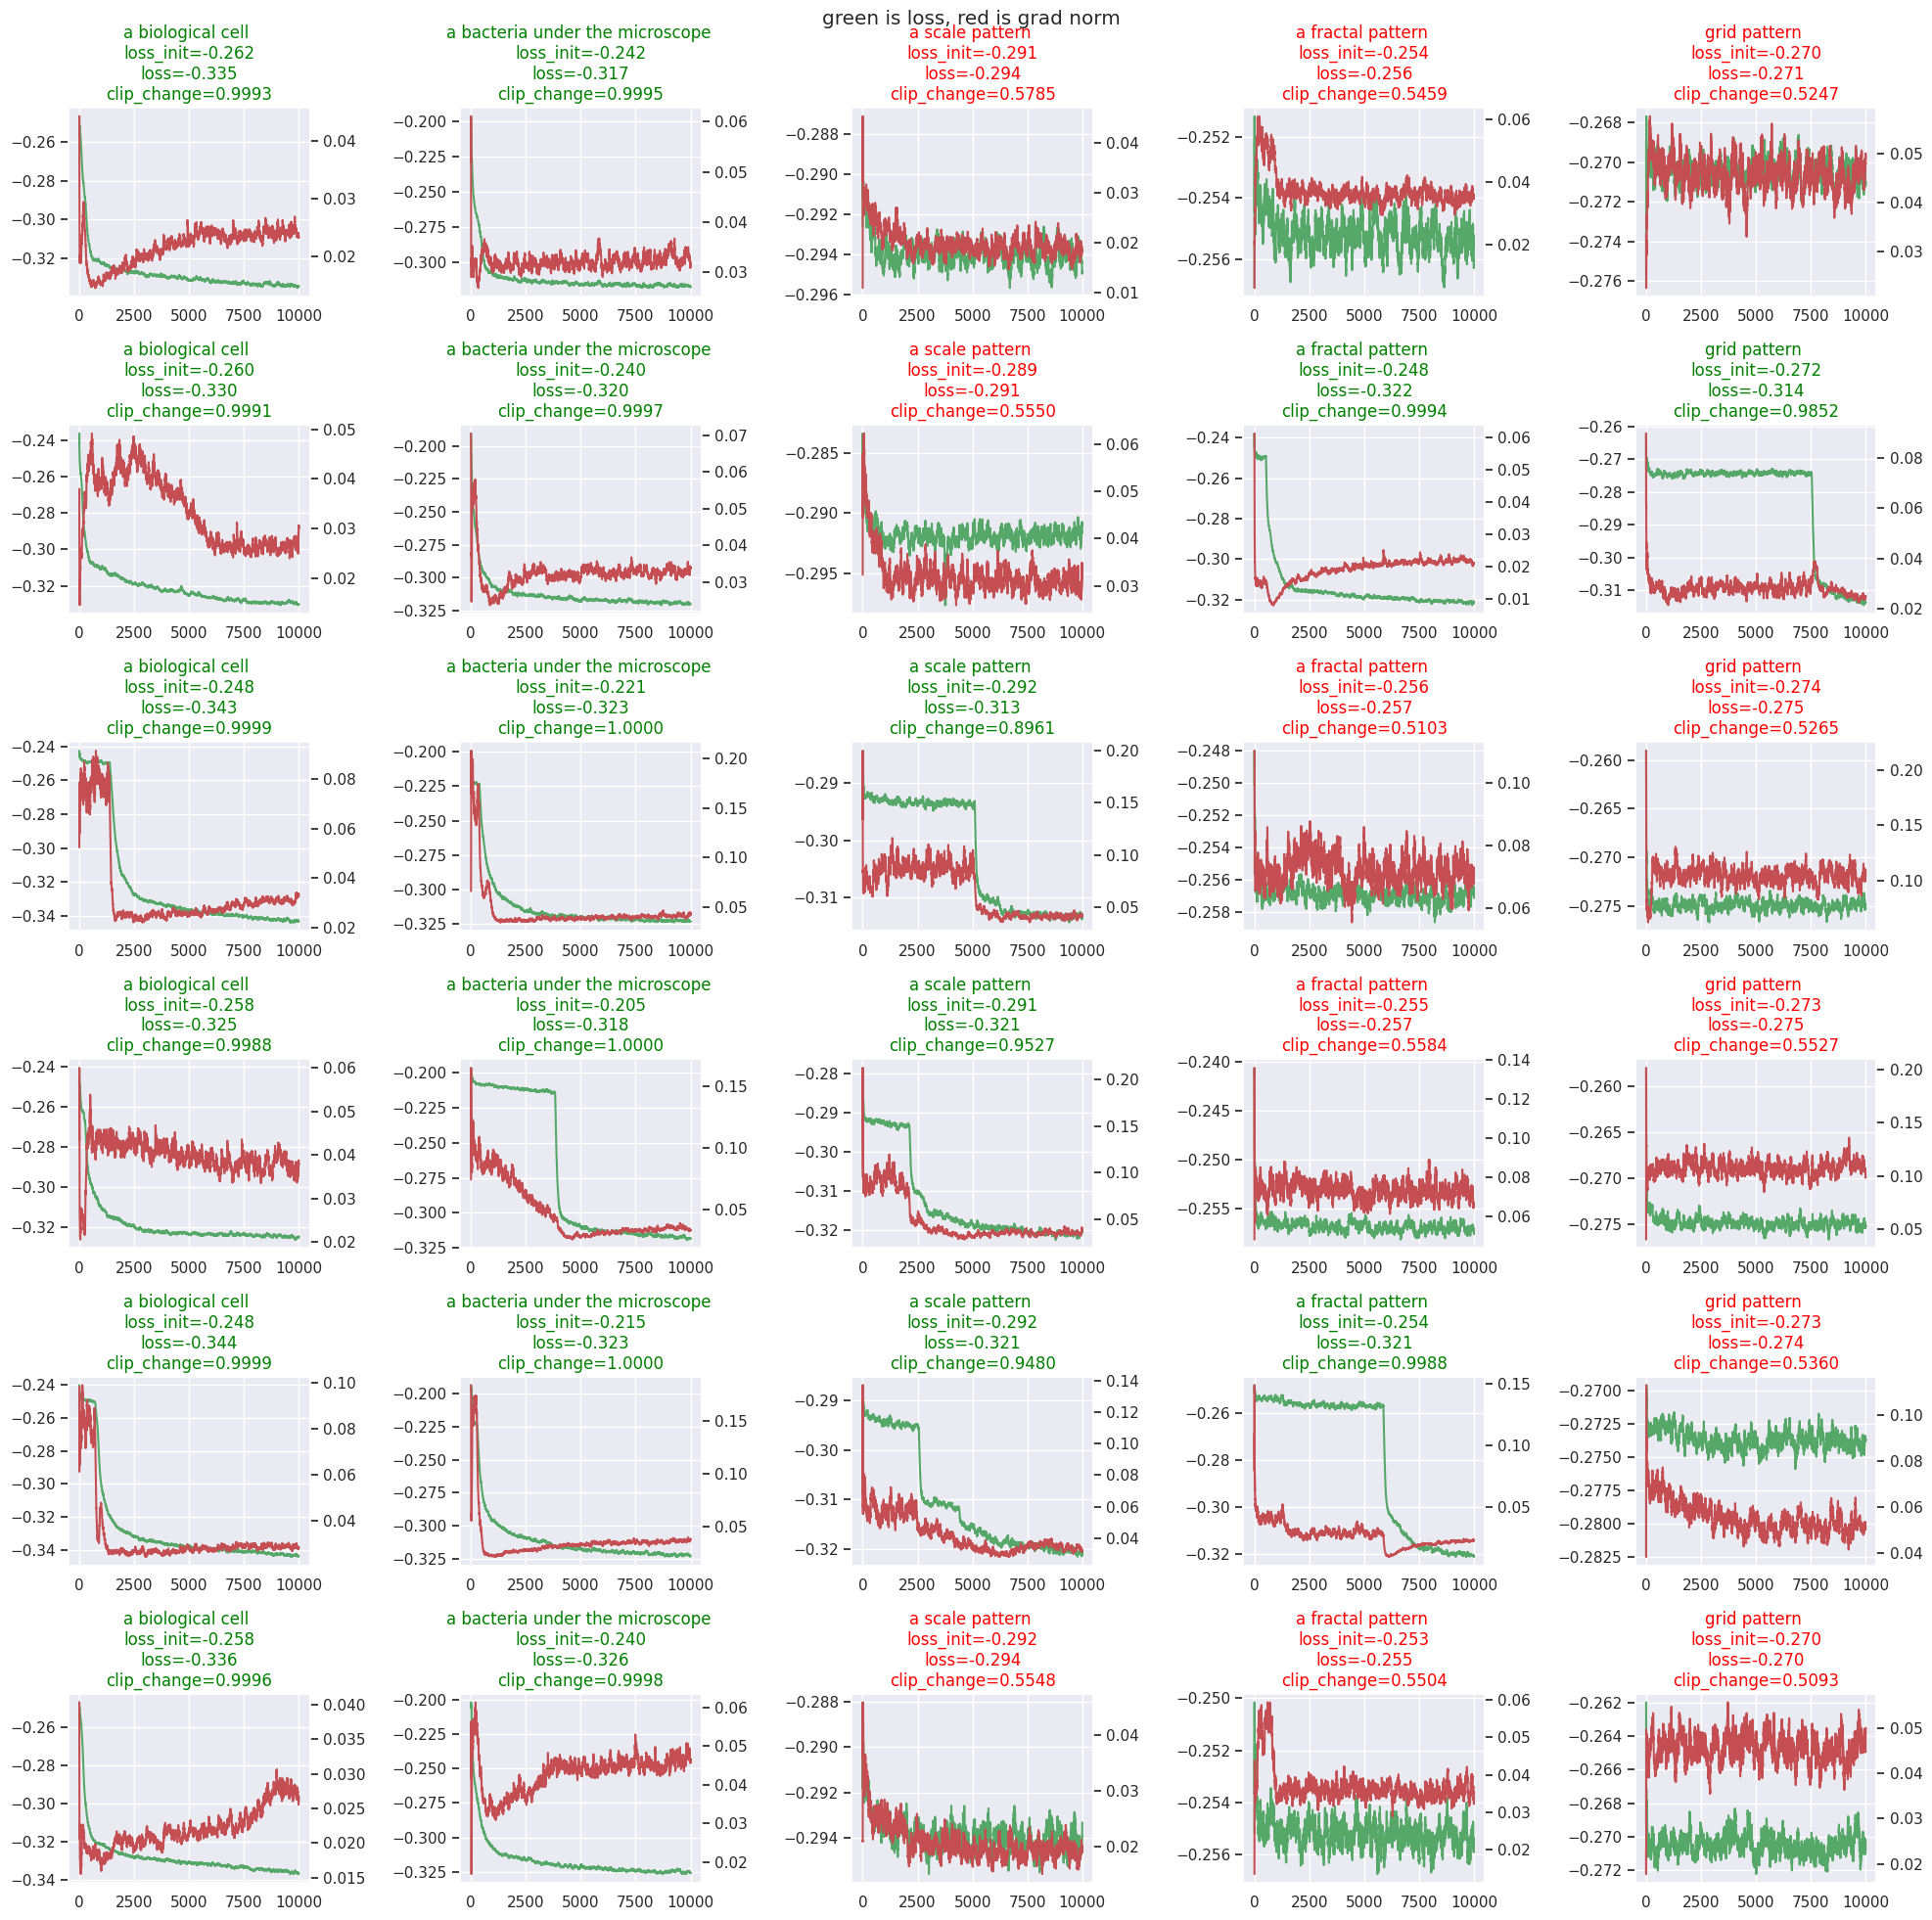

In [299]:
plt.figure(figsize=(20, 20))
iplt = 0

for i, dfi in tqdm(df[df['spatial_scales']!="1."].reset_index().iterrows()):
    data = util.load_pkl(dfi['save_dir'], "data")
    loss_init = util.load_pkl(dfi['save_dir'], 'data')['loss'][:100].mean().item()
    loss = util.load_pkl(dfi['save_dir'], 'data')['loss'][-100:].mean().item()
    clip_change = torch.softmax(torch.tensor([-loss_init, -loss])*100, dim=0)[-1].item()
    a = pd.DataFrame(data['loss']).ewm(span=100).mean().to_numpy()[:, 0]
    b = pd.DataFrame(data['grad_norm']).ewm(span=100).mean().to_numpy()[:, 0]
    
    iplt += 1
    plt.subplot(6, 5, iplt)

    plt.plot(a, color='g', label='loss')
    plt.gca().twinx().plot(b, color='r', label='grad norm')
    plt.title(f"{dfi['prompts']} \n{loss_init=:.3f}\n{loss=:.3f}\n{clip_change=:.4f}", color='red' if clip_change<0.75 else 'green')
    plt.grid(False)

plt.suptitle("green is loss, red is grad norm")
plt.tight_layout()
plt.show()

In [258]:
dfi = df[df['spatial_scales']!="1."].iloc[0]
data = util.load_pkl(dfi['save_dir'], 'data')

In [259]:
data.keys()

dict_keys(['loss_alignment', 'loss_temporal_softmax', 'loss_spatial_softmax', 'loss_temporal_novelty', 'loss_spatial_novelty', 'loss', 'grad_norm', 'grad_bptt'])

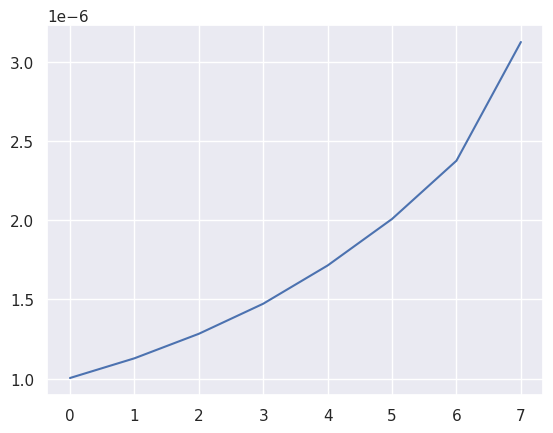

In [269]:
plt.plot(data['grad_bptt'][100])